In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from typing import Union
from tqdm import tqdm_notebook
import pylab
from statsmodels.stats.diagnostic import acorr_ljungbox

pd.options.mode.chained_assignment = None

In [83]:
# link to the file: https://www.dropbox.com/scl/fi/vfdtluzi31q9wh9g3v1re/co2.csv?rlkey=obbxo6j9sxv2a5qqjuknoo76u&st=qero9a8m&dl=0
!wget -O co2.csv https://www.dropbox.com/scl/fi/vfdtluzi31q9wh9g3v1re/co2.csv?rlkey=obbxo6j9sxv2a5qqjuknoo76u&st=qero9a8m&dl=0

--2024-05-27 20:11:08--  https://www.dropbox.com/scl/fi/vfdtluzi31q9wh9g3v1re/co2.csv?rlkey=obbxo6j9sxv2a5qqjuknoo76u
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfdeba06795f5dd9fb0f261d23c.dl.dropboxusercontent.com/cd/0/inline/CTuYztfSMmaS4Ye4DojL86OE8Gqf3KdVwDZstlTimXrDftXzd8LF0cmuM3CIkY2dnKdGICVDss93Rf_gNsNqOHw7LouJFihRf8dRyA92Smy3YgQJC2A7u827vj-bIDqL_Tnzgflyqbjfs20zfFM48MM3/file# [following]
--2024-05-27 20:11:09--  https://ucfdeba06795f5dd9fb0f261d23c.dl.dropboxusercontent.com/cd/0/inline/CTuYztfSMmaS4Ye4DojL86OE8Gqf3KdVwDZstlTimXrDftXzd8LF0cmuM3CIkY2dnKdGICVDss93Rf_gNsNqOHw7LouJFihRf8dRyA92Smy3YgQJC2A7u827vj-bIDqL_Tnzgflyqbjfs20zfFM48MM3/file
Resolving ucfdeba06795f5dd9fb0f261d23c.dl.dropboxusercontent.com (ucfdeba06795f5dd9fb0f261d23c.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:60

In [84]:
df = pd.read_csv('co2.csv')
print(df.shape)
df.head()

(45, 2)


,year,co2
0,1959,316.00
1,1960,316.91
2,1961,317.93
3,1962,318.46
4,1963,319.02


Text(0, 0.5, 'CO2, ppmv')

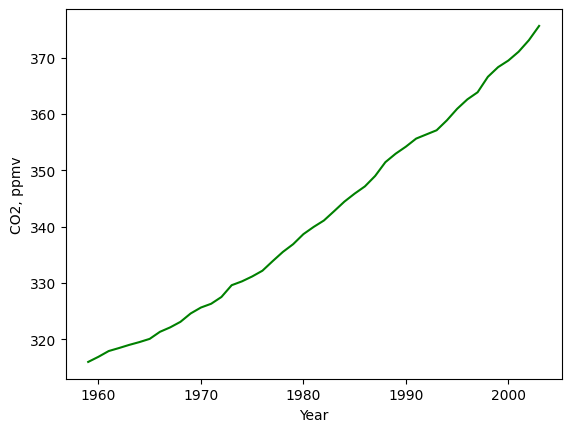

In [85]:
fig, ax = plt.subplots()
ax.plot(df['year'], df['co2'], 'g-')
ax.set_xlabel('Year')
ax.set_ylabel('CO2, ppmv')
# From here we can see overall growing trend with no visible seasonalities.

ADF-statistic: 3.870723022273591
p-value: 1.0
------------------
ADF-statistic: -3.2062597597220996
p-value: 0.019625187009388537
------------------


Text(0, 0.5, 'CO2, ppmv, differenced')

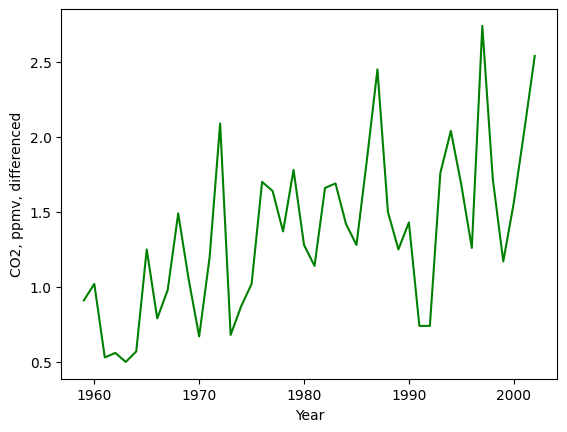

In [86]:
# ADF-test:
# Let's check for stationarity by running the ADF-test:
ADF_result = adfuller(df['co2'])
print(f'ADF-statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print('------------------')
# since we have a positive number representing our adf-statistic,
# as well as a p-value, which is equal to one we have to apply (at least)
# first-order differencing in order to achieve stationarity of our process.

# applying the 1st order differencing:
co2_diff = np.diff(df['co2'], n=1)
ADF_result = adfuller(co2_diff)
print(f'ADF-statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print('------------------')
# now p-value is smaller than 0.05 and adf-statistic is large negative number.

# Let's also plot what do we have now:

fig, ax = plt.subplots()
ax.plot(df['year'].values[:-1], co2_diff, 'g-')
ax.set_xlabel('Year')
ax.set_ylabel('CO2, ppmv, differenced')

In [87]:
# Since AIC can work with non-stationary processes,
# we can work with non-differenced dataset.
# train-test split (last 5 years will go to test):
train = df[:-5]
test = df[-5:]
print(train.shape, test.shape)
display(test)

(40, 2) (5, 2)


,year,co2
40,1999,368.30
41,2000,369.47
42,2001,371.03
43,2002,373.07
44,2003,375.61


In [88]:
# Defining range for p and q -- [0..3]:
p_values = range(0, 4, 1)
q_values = range(0, 4, 1)
# cartesian product for 2 sets:
order_list = list(product(p_values, q_values))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [89]:
# AIC:
def optimize_ARMA(endog, order_list):
  results = []
  for order in tqdm_notebook(order_list):
    try:
      model = SARIMAX(endog,
                      order=(order[0], 0, order[1]),
                      simple_differencing=False).fit(disp=False)
    except:
      continue
    aic = model.aic
    results.append([order, aic])
  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q)', 'AIC']
  result_df = result_df.sort_values(by='AIC',
                                    ascending=True).reset_index(drop=True)
  return result_df

result_df = optimize_ARMA(df['co2'], order_list)
display(result_df)

<ipython-input-89-7a393d5a5177>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

,"(p,q)",AIC
0,"(2, 0)",96.616867
1,"(3, 1)",100.284021
2,"(3, 0)",115.470311
3,"(1, 2)",125.709058
4,"(2, 3)",129.271278
5,"(2, 1)",137.532840
6,"(1, 1)",139.839851
7,"(3, 2)",140.385923
8,"(3, 3)",141.918517
9,"(2, 2)",142.196981


In [90]:
# as we can see the best result is shown with the following combination:
# (p, q) = (2, 0)
# so it is most likely that we have AR-2 process.

In [91]:
# so now in order to get the residuals we will apply SARIMAX-function for AR-2:
window_size = 1
pred_AR = []
df_new = df['co2']
for i in range(len(train),
               len(train) + len(test),
               window_size):
  model = SARIMAX(df_new[:i], order=(2,0,0))
  res = model.fit(disp=False)
  predictions = res.get_prediction(0, i + window_size - 1)
  oos_pred = predictions.predicted_mean.iloc[-window_size:]
  pred_AR.extend(oos_pred)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stat

[ 0.84074248  0.40051212 -0.50188051 -0.48209065 -0.50184101]


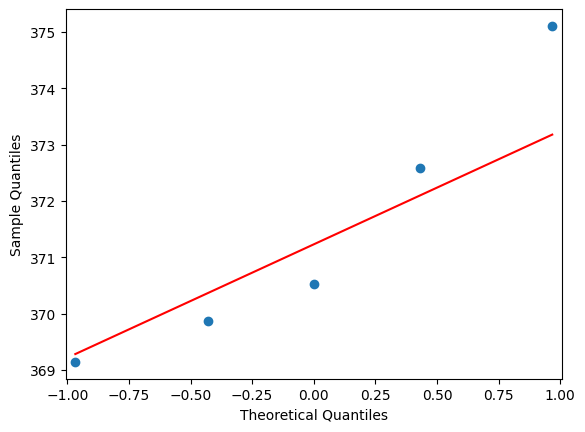

In [92]:
# q-q plot:
residuals = pred_AR - test['co2'].values
print(residuals)
sm.qqplot(np.array(pred_AR), line='q')
pylab.show()
# we can see that there is a slight offset for each value from line,
# but still they are pretty close to it (y = x).

In [93]:
# Ljung-Box test on the first 4 lags only, since the test size is quite small:
acorr_ljungbox(pred_AR, lags=4)
# as we can see from here all p-values are greater than 0.05,
# thus, we accept the null hypothesis and
# conclude that the residuals are independent (uncorrelated).

,lb_stat,lb_pvalue
1,1.082185,0.298209
2,1.280326,0.527206
3,3.545931,0.314854
4,8.121043,0.087244


In [95]:
# now it is time for predictions, we already have made them with sarimax function,
# the only one left is mean and last known method:
# historical mean:
historical_mean = np.mean(train['co2'])
pred_mean = np.full(len(test), historical_mean)
historical_mean_error = mean_squared_error(test['co2'], pred_mean)

# last known value:
pred_last_known = test['co2']
pred_last_known = np.roll(pred_last_known, 1)
pred_last_known[0] = train['co2'].values[-1]
next_value_error = mean_squared_error(test['co2'], pred_last_known)

# SARIMAX error calculations:
ar_error = mean_squared_error(test['co2'], pred_AR)

# historical mean over differenced:
train_diff = co2_diff[:-5]
test_diff = co2_diff[-5:]
historical_mean_diff = np.mean(train_diff)
pred_mean_diff = np.full(len(test_diff), historical_mean_diff)
pred_mean_rediff = np.zeros(5)
pred_mean_rediff = df['co2'].iloc[-5] + pred_mean_diff.cumsum()
historical_mean_diff_error = mean_squared_error(test_diff, pred_mean_diff)

In [96]:
print(historical_mean_error)
print(historical_mean_diff_error)
print(next_value_error)
print("MSE for SARIMAX:", ar_error)
print("MAE for SARIMAX:", mean_absolute_error(test['co2'], pred_AR))
# it is clearly seen, that we have the best MSE result is shown by SARIMAX func.
# Even though the mean for differenced is pretty close.

1133.0781240625013
0.47234331360948206
3.4748200000000296
MSE for SARIMAX: 0.3206795430156298
MAE for SARIMAX: 0.545413353585127


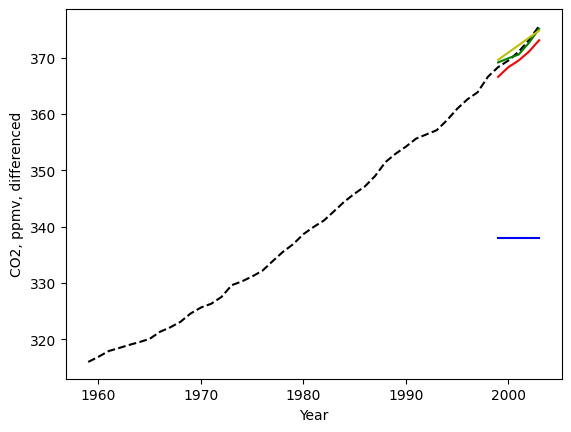

In [97]:
# plotting the predictions (mean, last known and AR):
fig, ax = plt.subplots()
ax.plot(df['year'], df['co2'], 'k--')
ax.set_xlabel('Year')
ax.set_ylabel('CO2, ppmv, differenced')
ax.plot(df['year'].values[-5:], pred_mean, 'b-')
ax.plot(df['year'].values[-5:], pred_last_known, 'r-')
ax.plot(df['year'].values[-5:], pred_AR, 'g-')
ax.plot(df['year'].values[-5:], pred_mean_rediff, 'y-')